In [7]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
from scipy import stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import pickle
import csv

In [5]:
rlist = []
records = os.path.normpath('mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [64]:
for record in rlist:
    os.remove(os.path.normpath("mit-bih-extracted/" + record + "_rr_ints.csv"))
    os.remove(os.path.normpath("mit-bih-extracted/" + record + "_drmean_variance.csv"))
    os.remove(os.path.normpath("mit-bih-extracted/" + record + "_rr_rhythms.csv"))

In [23]:
subject_dfs = {}
for record in rlist:
    subject_dfs[record] = pd.read_csv("mit-bih-subsets/" + record + "_subset_list.csv", index_col=0)

In [24]:
for record in tqdm(rlist):
    rmean_variance = []
    drmean_variance = []
    for row in subject_dfs[record].itertuples():
        subset = pd.read_csv("mit-bih-subsets/"+record+"/"+row.subsetID)
        rmean_variance.append(subset['rmean'].var())
        drmean_variance.append(subset['drmean'].var())
    subject_dfs[record]['rmean_variance'] = rmean_variance
    subject_dfs[record]['drmean_variance'] = drmean_variance

100%|███████████████████████████████████████████| 23/23 [01:14<00:00,  3.23s/it]


In [71]:
def plot_time_plot(data, selection, column, nrows, ncols, title, xlabel, ylabel):
    plt.figure(figsize=(28, 18), constrained_layout=True)
    
    for idx, x in enumerate(selection):
        ax = plt.subplot(nrows, ncols, idx + 1)
        ax.set_title('Subject '+x, fontsize=28)
        ax.set_xlabel(xlabel, fontsize=24)
        ax.set_ylabel(ylabel, fontsize=24)
        ax.tick_params(labelsize=22)

        df = data[x]

        current = df['rhythmLabel'][0]
        currentdata = []
        lastidx = 0
        print("Plot "+str(idx+1)+", Subject "+x)
        for index, row in tqdm(df.iterrows()):
            if index == len(df)-1:
                currentdata.append(row[column])
                if current == 'N':
                    ax.plot(list(range(lastidx, index+1)), currentdata, color='darkcyan')
                elif current == 'A':
                    ax.plot(list(range(lastidx, index+1)), currentdata, color='orange')
                elif current == 'O':
                    ax.plot(list(range(lastidx, index+1)), currentdata, color='salmon')
            elif row['rhythmLabel'] == current:
                currentdata.append(row[column])
            else:
                if current == 'N':
                    ax.plot(list(range(lastidx, index)), currentdata, color='darkcyan')
                elif current == 'A':
                    ax.plot(list(range(lastidx, index)), currentdata, color='orange')
                elif current == 'O':
                    ax.plot(list(range(lastidx, index)), currentdata, color='salmon')
                lastidx = index
                current = row['rhythmLabel']
                currentdata = [row[column]]

        ax.axhline(y=df[df['rhythmLabel'] == 'N'][column].mean(), color="darkslategray", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'A'][column].mean(), color="purple", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'O'][column].mean(), color="darkred", linestyle="--", linewidth=5)

    plt.suptitle(title, fontsize=36)

    normal_patch = mpatches.Patch(color='darkcyan', label='Normal')
    afib_patch = mpatches.Patch(color='orange', label='Afib')
    other_patch = mpatches.Patch(color='salmon', label='Other')
    normal_mean_patch = mpatches.Patch(color='darkslategray', label='Normal mean')
    afib_mean_patch = mpatches.Patch(color='purple', label='Afib mean')
    other_mean_patch = mpatches.Patch(color='darkred', label='Other mean') 
    plt.figlegend(handles=[normal_patch, afib_patch, other_patch, normal_mean_patch, afib_mean_patch, other_mean_patch],
                fontsize=28, 
                loc = "upper right",
                ncol=2,
                shadow = True)

In [62]:
def numeric_summary(data, selection, column):
    for x in selection:
        df = data[x]
        print('Subject '+x+' summary, by rhythm')
        stats = pd.DataFrame([df[df['rhythmLabel'] == 'N'][column].describe(), df[df['rhythmLabel'] == 'A'][column].describe(), df[df['rhythmLabel'] == 'O'][column].describe()], index=['normal', 'Afib', 'other'])
        print(stats)

Plot 1, Subject 04908


2442it [00:00, 13984.09it/s]


Plot 2, Subject 08455


2379it [00:00, 16889.13it/s]


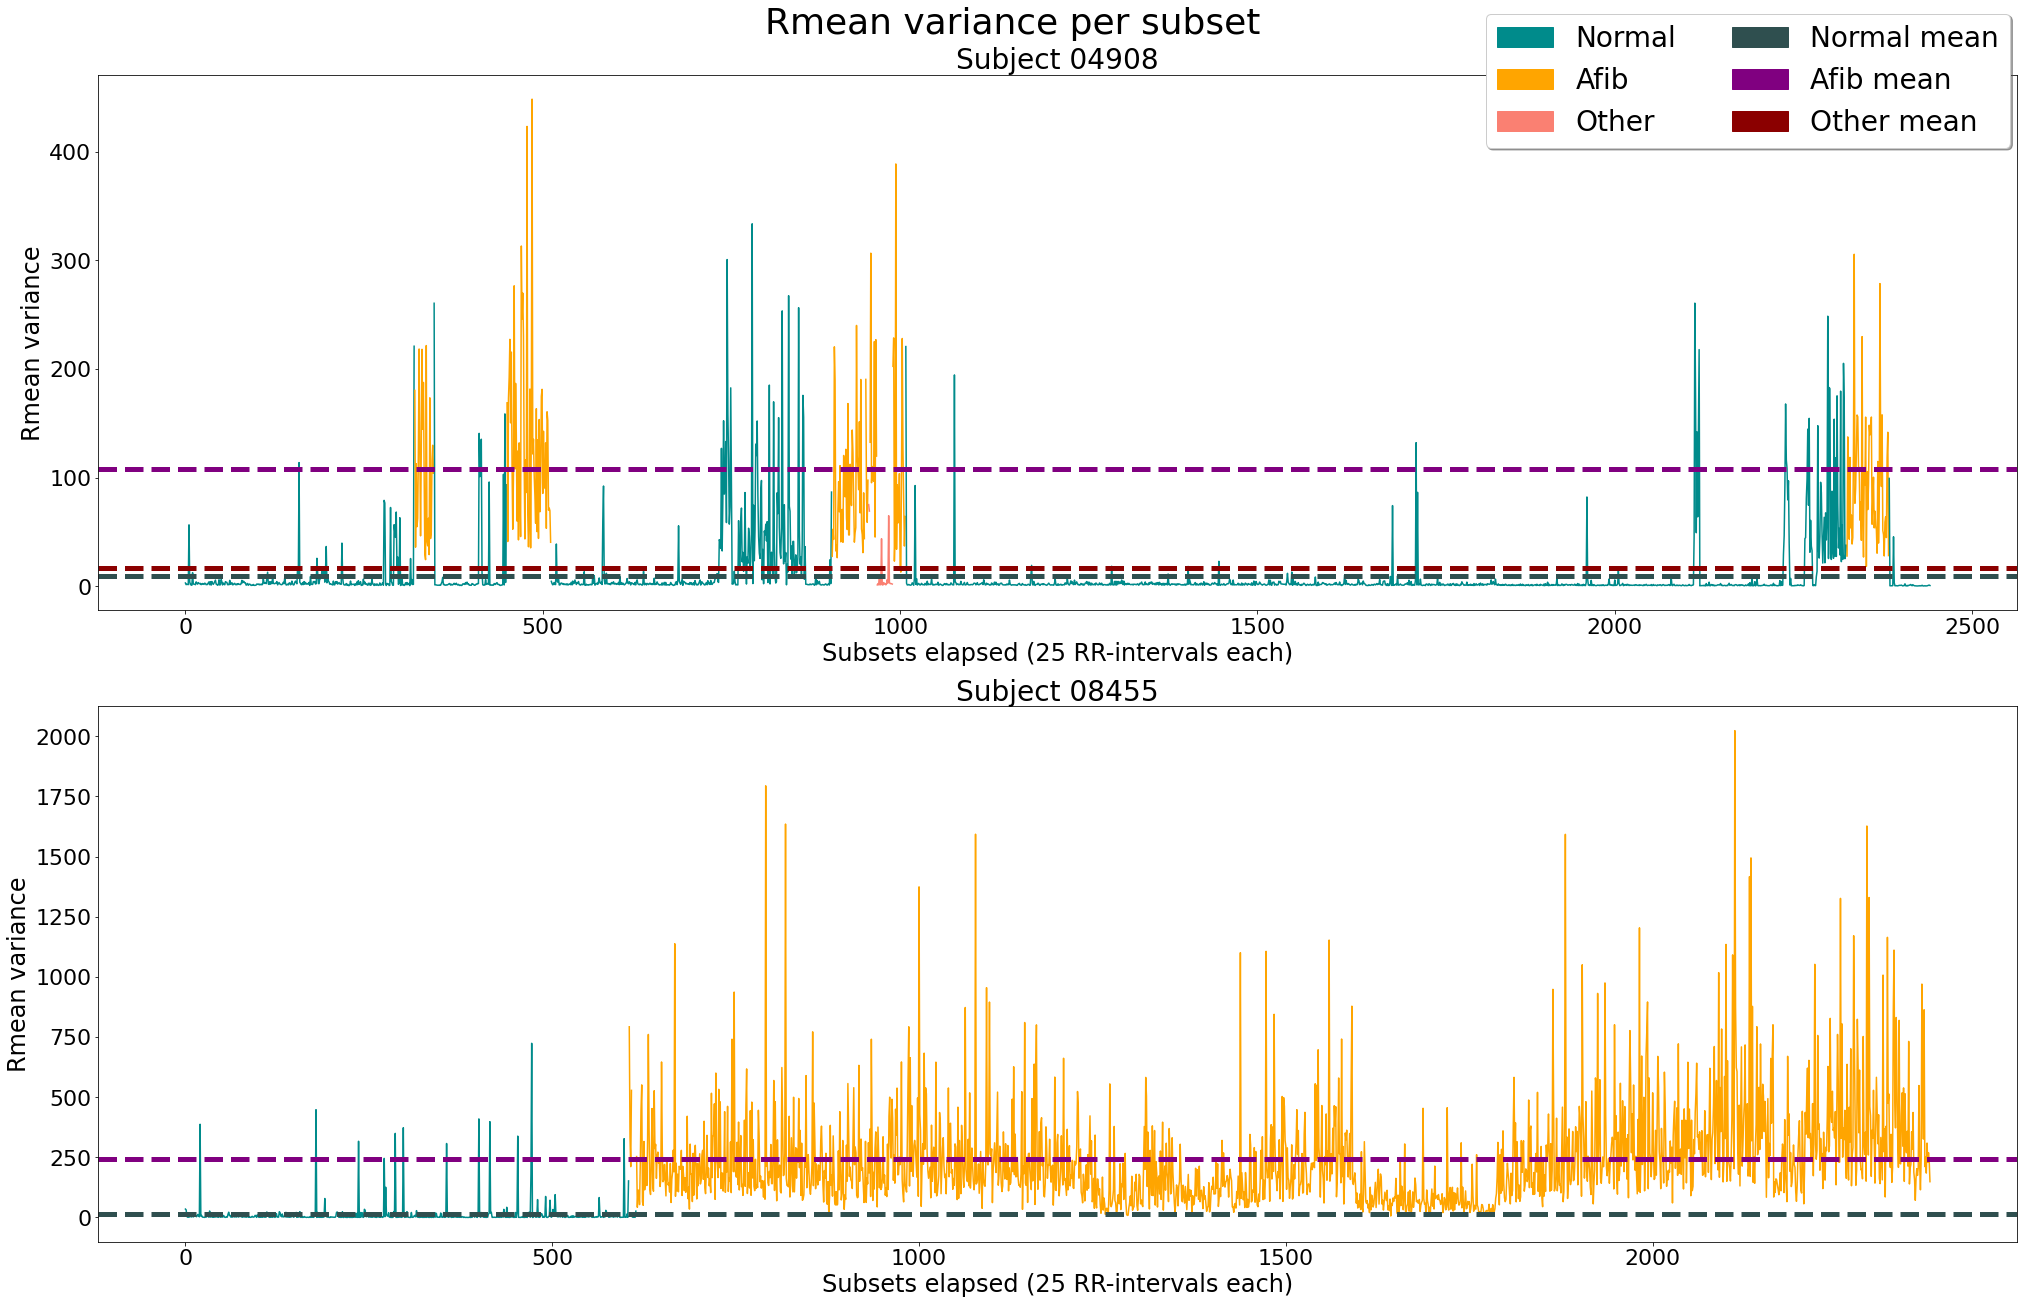

: 

In [73]:
plot_time_plot(subject_dfs, ['04908', '08455'], 'rmean_variance', 2, 1, 'Rmean variance per subset', 'Subsets elapsed (25 RR-intervals each)', 'Rmean variance')

In [63]:
numeric_summary(subject_dfs, rlist, 'rmean_variance')

Subject 04015 summary, by rhythm
         count        mean         std        min         25%         50%  \
normal  1703.0   41.489346  142.507582   0.068695    1.084687    2.582541   
Afib      10.0  417.176756  349.042690  25.285440  187.649152  329.140593   
other      0.0         NaN         NaN        NaN         NaN         NaN   

               75%          max  
normal    8.060428  2453.811227  
Afib    528.860644  1078.737584  
other          NaN          NaN  
Subject 04043 summary, by rhythm
         count        mean         std        min        25%        50%  \
normal  1887.0   16.182527   61.036634   0.052706   0.514317   0.985440   
Afib     560.0  125.155515  105.903468   0.135444  52.887602  91.326357   
other      1.0   59.452009         NaN  59.452009  59.452009  59.452009   

               75%          max  
normal    2.674742  1024.392194  
Afib    161.193007   725.009686  
other    59.452009    59.452009  
Subject 04048 summary, by rhythm
         count     